In [3]:
from monai.utils import first, set_determinism
from monai.transforms import (
    Compose,
    EnsureChannelFirstd,
    LoadImaged,
    Orientationd, 
    Spacingd,
    Resized,
    ScaleIntensityRanged,
    CropForegroundd,
    Activations,
    ToTensord
)

from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.data import DataLoader, Dataset

import torch
import matplotlib.pyplot as plt

import os
from glob import glob
import numpy as np
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference

In [4]:
train_loss = np.load('/Users/vaidehitaraklad/Machine Learning/Jupyter/Projects/Liver Segmentation/results/loss_train.npy')
test_loss = np.load('/Users/vaidehitaraklad/Machine Learning/Jupyter/Projects/Liver Segmentation/results/loss_test.npy')
train_metric = np.load('/Users/vaidehitaraklad/Machine Learning/Jupyter/Projects/Liver Segmentation/results/metric_train.npy')
test_metric = np.load('/Users/vaidehitaraklad/Machine Learning/Jupyter/Projects/Liver Segmentation/results/metric_test.npy')

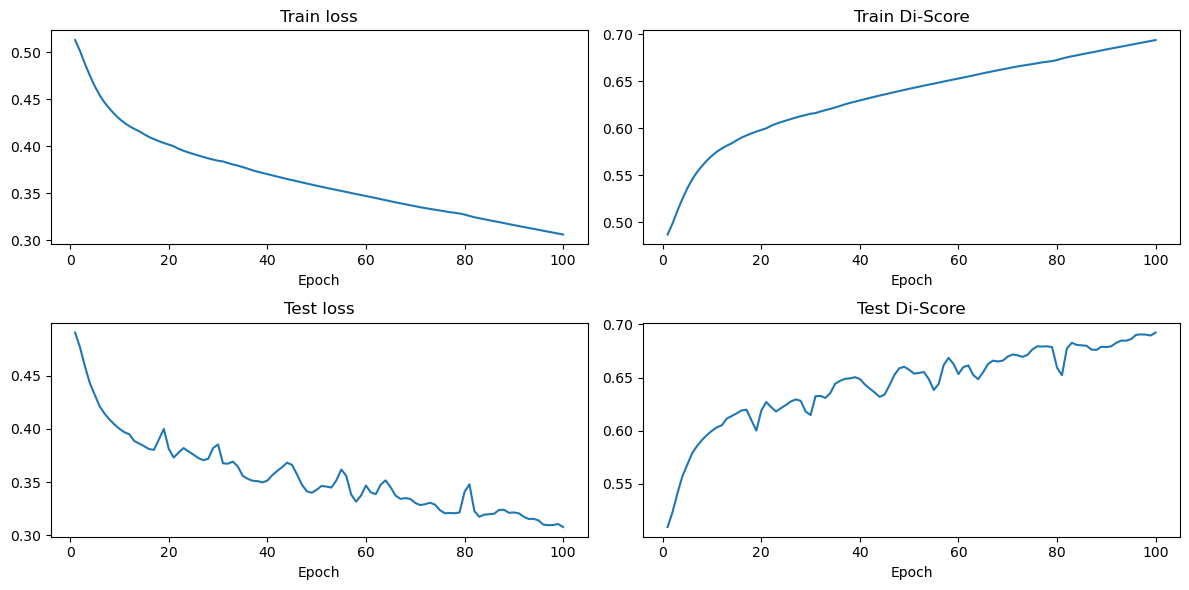

In [4]:
plt.figure("Results", (12,6))

plt.subplot(2,2,1)
plt.title('Train loss')
x = np.arange(1, len(train_loss) + 1)
plt.xlabel('Epoch')
plt.plot(x, train_loss)

plt.subplot(2,2,3)
plt.title('Test loss')
x = np.arange(1, len(test_loss) + 1)
plt.xlabel('Epoch')
plt.plot(x, test_loss)

plt.subplot(2,2,2)
plt.title('Train Di-Score')
x = np.arange(1, len(train_metric) + 1)
plt.xlabel('Epoch')
plt.plot(x, train_metric)

plt.subplot(2,2,4)
plt.title('Test Di-Score')
x = np.arange(1, len(test_metric) + 1)
plt.xlabel('Epoch')
plt.plot(x, test_metric)

plt.tight_layout()
plt.show()

In [22]:
train_images = sorted(glob('/Users/vaidehitaraklad/Machine Learning/Jupyter/Projects/Liver Segmentation/niftifiles/images/*'))
train_labels = sorted(glob('/Users/vaidehitaraklad/Machine Learning/Jupyter/Projects/Liver Segmentation/niftifiles/labels/*'))

test_images = sorted(glob('/Users/vaidehitaraklad/Machine Learning/Jupyter/Projects/Liver Segmentation/niftifiles/images_test/*'))
test_labels = sorted(glob('/Users/vaidehitaraklad/Machine Learning/Jupyter/Projects/Liver Segmentation/niftifiles/labels_test/*'))

train_files = [{'image': image_name, 'label': label_name} for image_name, label_name in zip(train_images, train_labels)]
val_files = [{'image': image_name, 'label': label_name} for image_name, label_name in zip(test_images, test_labels)]
val_files = val_files[0:9]
# train_files = val_files[6:9]

val_transform = Compose(
    [
        LoadImaged(keys=['image', 'label']),
        EnsureChannelFirstd(keys=['image', 'label']),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=['image', 'label'], pixdim=(1.5, 1.5, 1.0), mode=('bilinear', 'nearest')),
        ScaleIntensityRanged(keys=['image'], a_min=-200, a_max = 200, b_min = 0.0, b_max = 1.0, clip = True),
        CropForegroundd(keys=['image', 'label'], source_key='image'),
        Resized(keys=['image', 'label'], spatial_size=[128, 128, 64]),
        ToTensord(keys=['image', 'label'])
    ]
)

test_ds = Dataset(data = val_files, transform=val_transform)
test_loader = DataLoader(test_ds, batch_size=1)


In [24]:
device = torch.device('cpu')
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2,2,2,2),
    num_res_units=2,
    norm=Norm.BATCH
).to(device)

In [26]:
result_dir = '/Users/vaidehitaraklad/Machine Learning/Jupyter/Projects/Liver Segmentation/results'
model.load_state_dict(torch.load(
    os.path.join(result_dir, 'best_metric_model.pth')))
model.eval()

/var/folders/ws/yv9j568n2jb6_6brg48628qm0000gn/T/ipykernel_6089/2637224521.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(


UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(


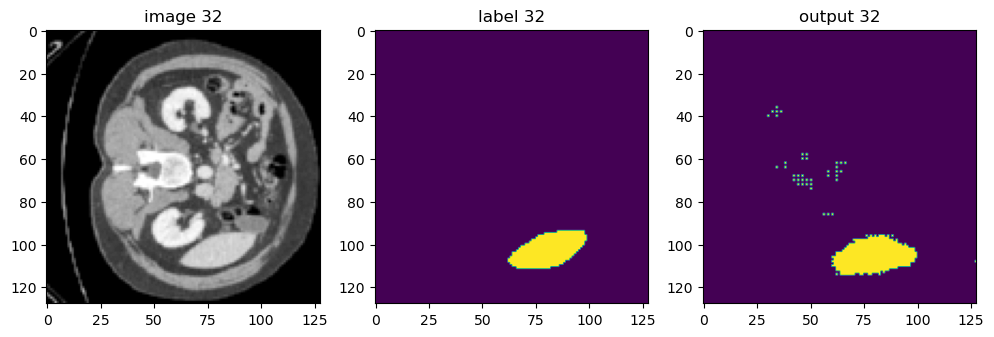

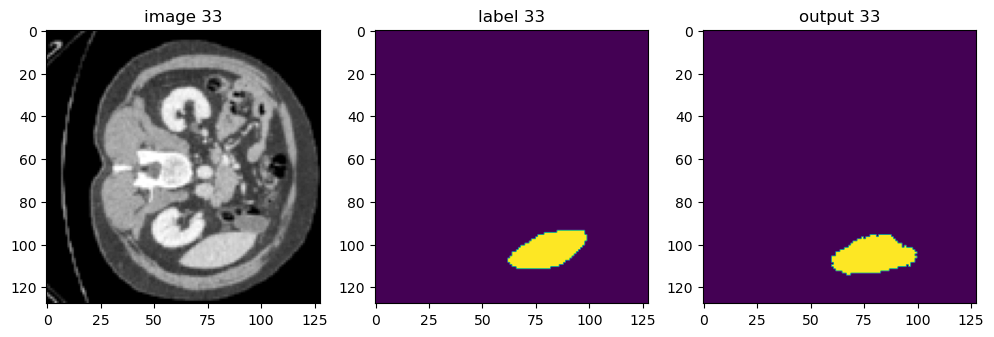

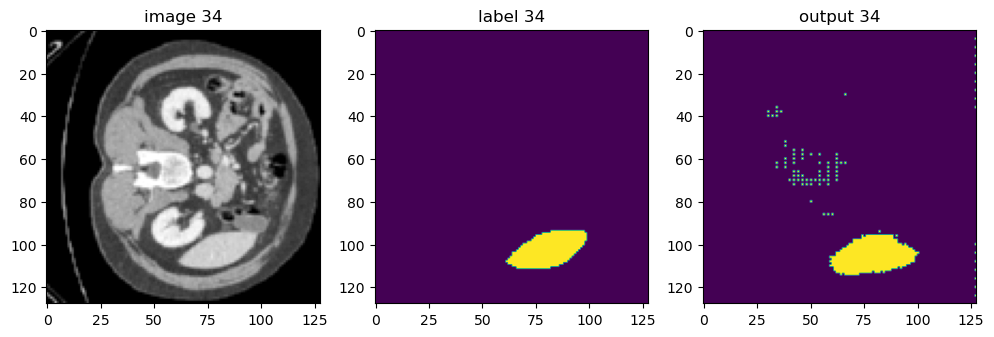

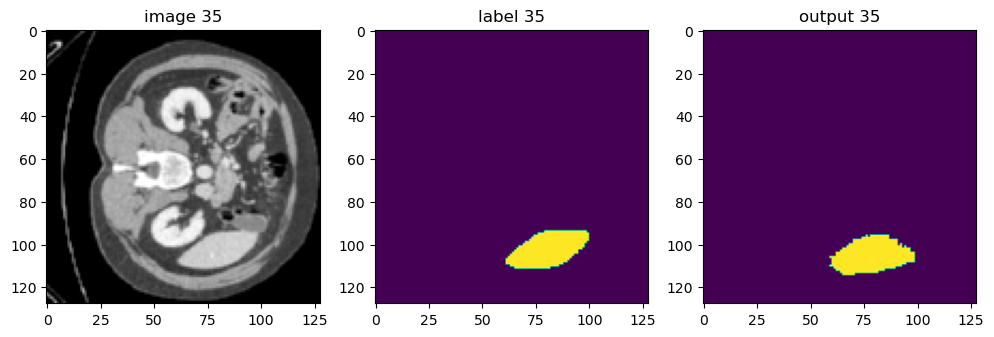

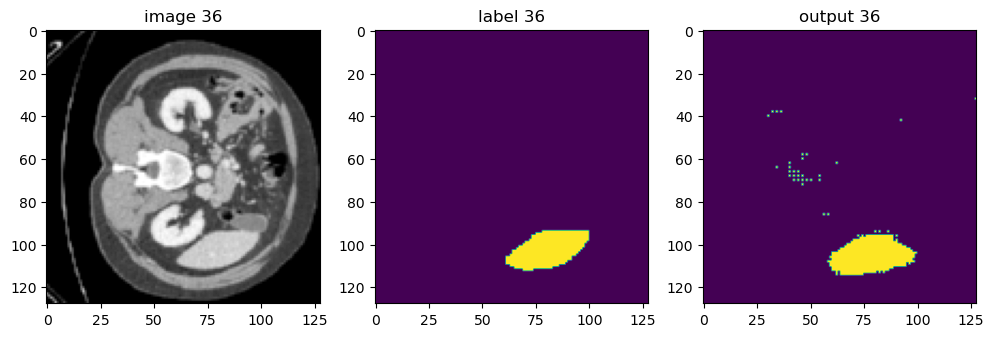

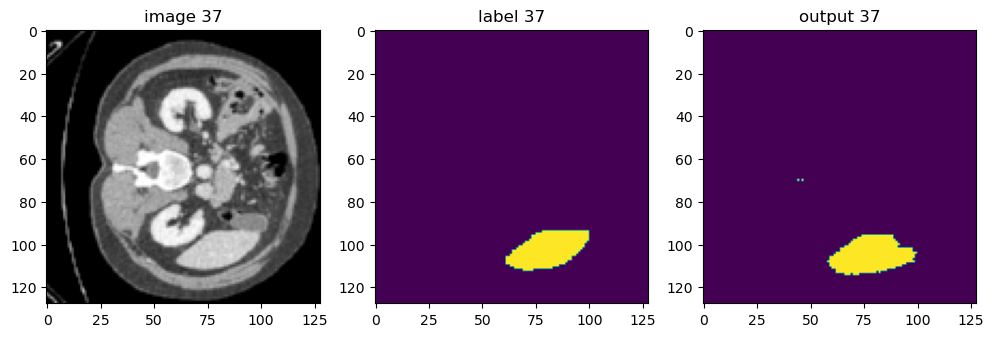

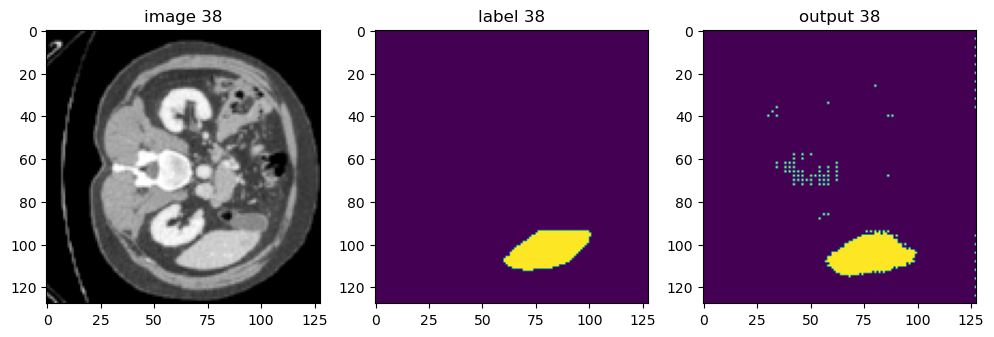

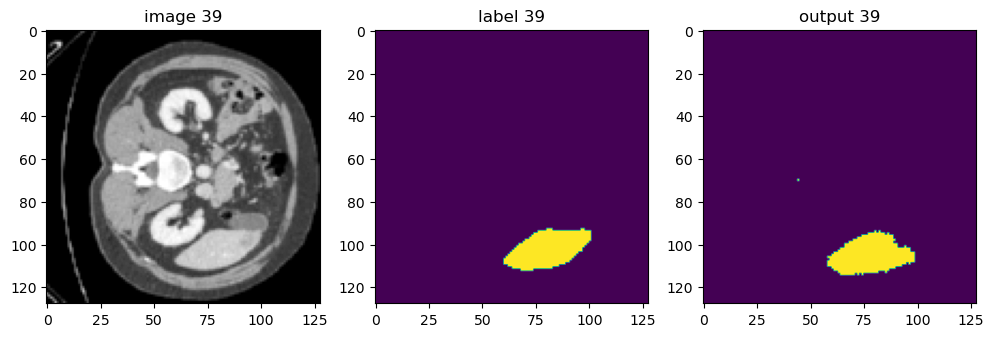

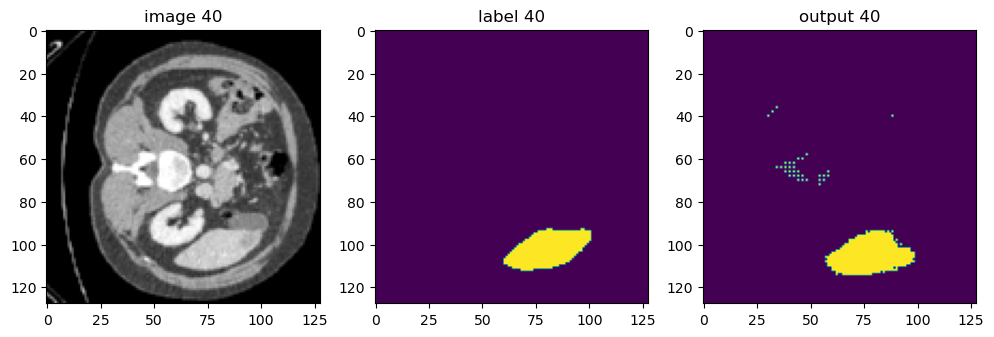

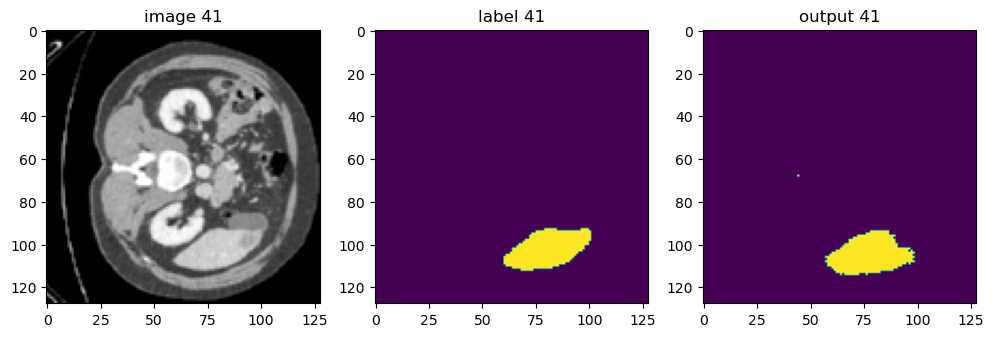

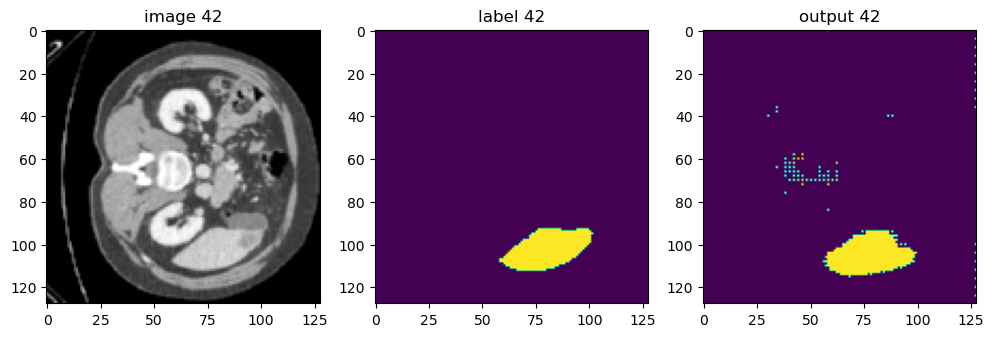

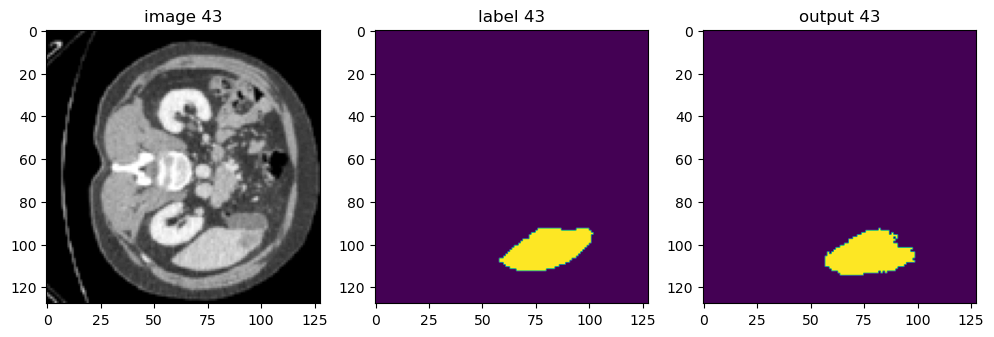

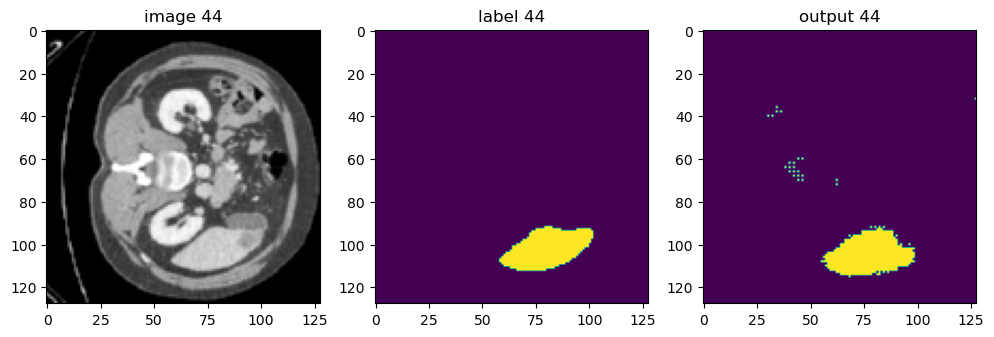

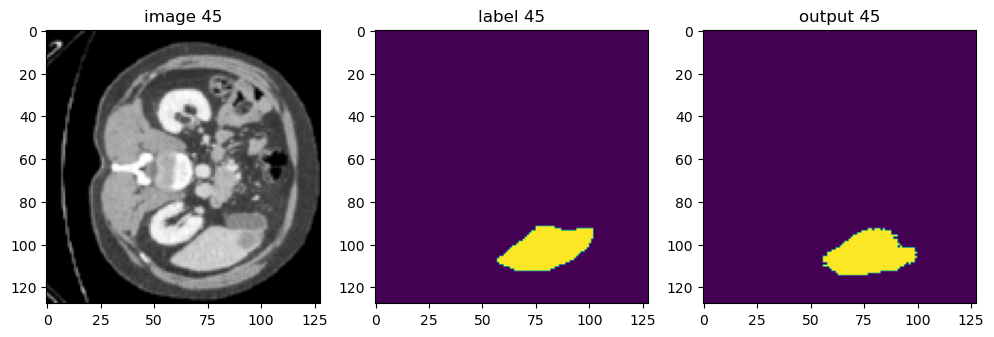

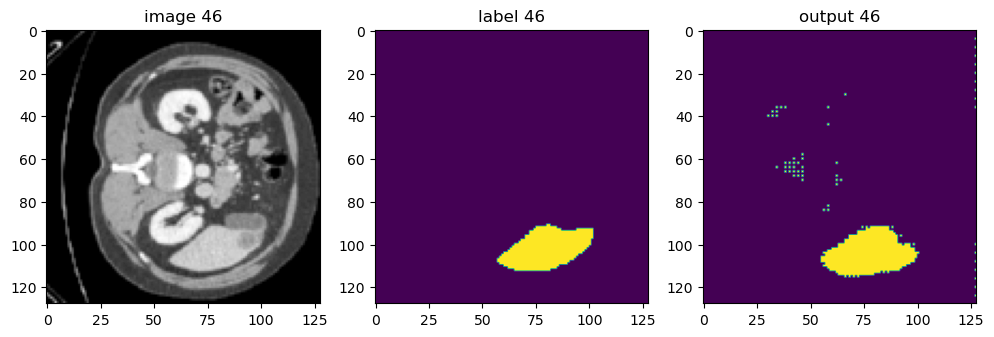

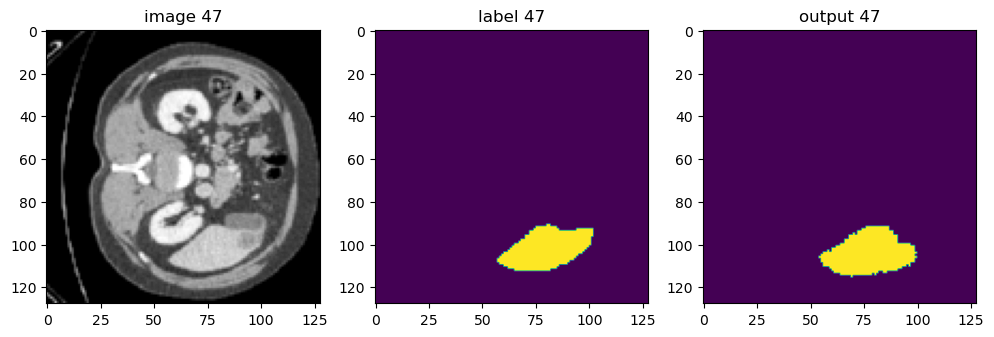

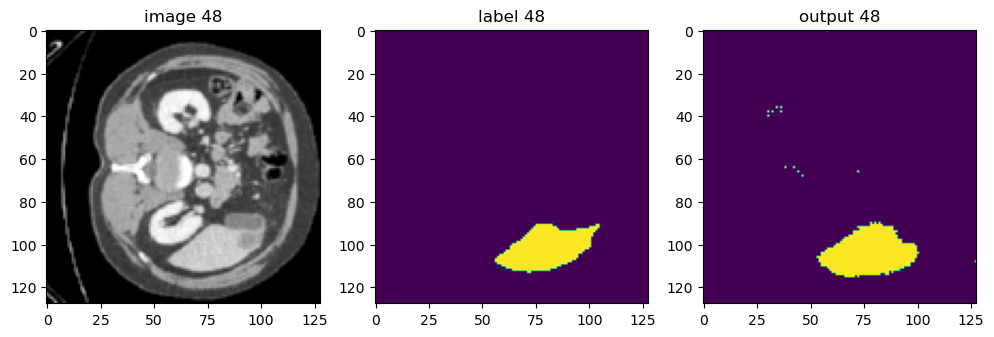

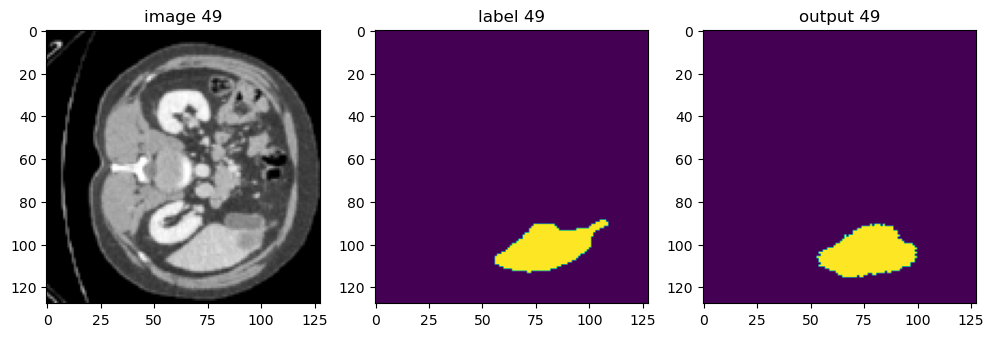

In [28]:
sw_batch_size = 4 
roi_size = (128, 128, 64)
with torch.no_grad():
    test_patient = first(test_loader)
    t_volume = test_patient['image']
    
    test_outputs = sliding_window_inference(t_volume.to(device), roi_size, sw_batch_size, model)
    sigmoid_activation = Activations(sigmoid=True)
    test_outputs = sigmoid_activation(test_outputs)
    test_outputs = test_outputs > 0.53
        
    for i in range(32,50):
        plt.figure("check", (12, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(test_patient["image"][0, 0, :, :, i], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(test_patient["label"][0, 0, :, :, i]!=0)
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(test_outputs.detach().cpu()[0, 1, :, :, i])
        plt.show()